# Healthcare Fraud Detection using Unsupervised Graph Neural Networks

This notebook demonstrates how to build an unsupervised Graph Neural Network (GNN) model to detect anomalies in healthcare provider data. We will transform tabular data into a graph structure, train a Graph Autoencoder (GAE) to learn normal patterns, and identify providers with high reconstruction errors as potential anomalies.

## Step 1: Import Libraries and Set Device
We will use `pandas` for data manipulation, `scikit-learn` for preprocessing and graph construction, `torch` and `torch_geometric` for the GNN model, and `networkx` / `matplotlib` for visualization.

In [1]:
#to array the data in multidimensional array(tensor) and apply operations on them
import torch
import torch.nn as nn
import torch.nn.functional as F

#provide the math to handle logic and edges
from torch_geometric.data import Data
from torch_geometric.nn import GAE, GCNConv

#to be able to build,manipulate and measure graph to be able to manipulate it
from torch_geometric.utils import from_networkx
import networkx as nx

#to be able to extract and visulisation of data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#to be able to stretch each feature(column) in an level playing field, majorily b/w [-1,1] or [0,1]<------normalization
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

c:\Users\Anshu Yadav\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


## Step 2: Data Preprocessing

Here, we load the `Healthcare Providers.csv` dataset. We'll select features related to claims, payments, and services.  Numerical features are normalized using `StandardScaler` to ensure they contribute equally to the distance calculations. For simplicity, we will focus on numerical features for building the graph.

In [2]:
#focusing on the numberical data only to keep the project simple
# Load Dataset
try:
    df = pd.read_csv('Healthcare Providers.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Dataset not found. Please ensure 'Healthcare Providers.csv' is in the same directory.")
    
# Display first few rows
print(df.head())

# Select relevant numerical features
# Features related to services, beneficiaries, and payment amounts
features = [
    'Number of Services',
    'Number of Medicare Beneficiaries',
    'Number of Distinct Medicare Beneficiary/Per Day Services',
    'Average Medicare Allowed Amount',
    'Average Submitted Charge Amount',
    'Average Medicare Payment Amount',
    'Average Medicare Standardized Amount'
]

# Clean the data: Remove commas and convert to float for numerical columns
for col in features:
    # Check if the column exists in the dataframe to avoid KeyErrors
    if col in df.columns:
        # Convert to string, remove commas, then convert to numeric
        # 'coerce' turns unparseable values (like empty strings) into NaN
        df[col] = df[col].astype(str).str.replace(',', '').apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values in selected features (if any)
df_clean = df.dropna(subset=features).copy()

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[features])

# Convert to PyTorch tensor
x = torch.tensor(X_scaled, dtype=torch.float)

print(f"Feature matrix shape: {x.shape}")

Dataset loaded successfully.
     index  National Provider Identifier  \
0  8774979                    1891106191   
1  3354385                    1346202256   
2  3001884                    1306820956   
3  7594822                    1770523540   
4   746159                    1073627758   

  Last Name/Organization Name of the Provider First Name of the Provider  \
0                                 UPADHYAYULA                  SATYASREE   
1                                       JONES                      WENDY   
2                                    DUROCHER                    RICHARD   
3                                     FULLARD                     JASPER   
4                                    PERROTTI                    ANTHONY   

  Middle Initial of the Provider Credentials of the Provider  \
0                            NaN                        M.D.   
1                              P                        M.D.   
2                              W                         

## Step 3: Graph Construction with KNN

Since this is tabular data without explicit connections between providers, we will construct a graph based on feature similarity. We will use the K-Nearest Neighbors (KNN) algorithm to connect each provider to their 5 (or 10) most similar peers. This creates a graph where similar providers are connected.
**Note**: For very large datasets, processing all nodes can be memory-intensive. For demonstration, we might sample the data if it exceeds memory capacity, but here we process the whole or a subset for efficiency.

In [3]:
# Sampling for demo purposes (Processing 100k+ nodes might be slow on CPU for KNN)
# You can use the full dataset if you have powerful hardware.
SAMPLE_SIZE = 10000 
if len(df_clean) > SAMPLE_SIZE:
    # Shuffle and pick sample
    indices = np.random.choice(len(df_clean), SAMPLE_SIZE, replace=False)
    x_sample = x[indices]
    df_sample = df_clean.iloc[indices].reset_index(drop=True)
    print(f"Subsampled to {SAMPLE_SIZE} providers for graph construction.")
else:
    x_sample = x
    df_sample = df_clean
    print(f"Using all {len(df_clean)} providers.")

# Construct KNN Graph
# Connect each node to its top 5 similar neighbors based on features
k = 5
adj_matrix = kneighbors_graph(x_sample, k, mode='connectivity', include_self=False)

# Convert sparse matrix to PyTorch Geometric compatible edge_index
edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)

# create PyTorch Geometric Data object
data = Data(x=x_sample, edge_index=edge_index)

print(f"Graph Data: {data}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")

Subsampled to 10000 providers for graph construction.
Graph Data: Data(x=[10000, 7], edge_index=[2, 50000])
Number of nodes: 10000
Number of edges: 50000


## Step 4: Define Graph Autoencoder (GAE) Model

We will define a simple Graph Autoencoder. The **Encoder** will be a Graph Convolutional Network (GCN) that takes the node features and the graph structure and compresses them into a lower-dimensional latent space (embedding). The **Decoder** (automatic in `GAE`) tries to reconstruct the adjacency matrix from these embeddings. The goal is that the model will learn to represent "normal" provider connections well, but struggle with anomalies.

In [4]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        # Two GCN layers
        # Compresses features to a hidden dimension, then to latent dimension
        self.conv1 = GCNConv(in_channels, 2 * out_channels) 
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# Initialize model
num_features = data.x.shape[1]
latent_dim = 16  # Size of the compressed representation
encoder = GCNEncoder(in_channels=num_features, out_channels=latent_dim)
model = GAE(encoder)

model = model.to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)

GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(7, 32)
    (conv2): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)


## Step 5: Training the Model

We train the model to minimize the reconstruction loss. The model learns to encode the node features and connections into a latent space. Successful training means the model can reconstruct the edges of the graph from the latent space. Anomalies, which deviate from typical patterns, will be harder to reconstruct perfectly (though GAE focuses on edge reconstruction, we can also look at feature reconstruction if using a standard Autoencoder, but here we focus on structural anomalies).

C:\Users\Anshu Yadav\AppData\Local\Temp\ipykernel_32240\2822512994.py:11: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  return float(loss)


Epoch: 020, Loss: 1.1921
Epoch: 040, Loss: 1.1174
Epoch: 060, Loss: 1.0663
Epoch: 080, Loss: 1.0166
Epoch: 100, Loss: 0.9893
Epoch: 120, Loss: 0.9790
Epoch: 140, Loss: 0.9642
Epoch: 160, Loss: 0.9563
Epoch: 180, Loss: 0.9488
Epoch: 200, Loss: 0.9406


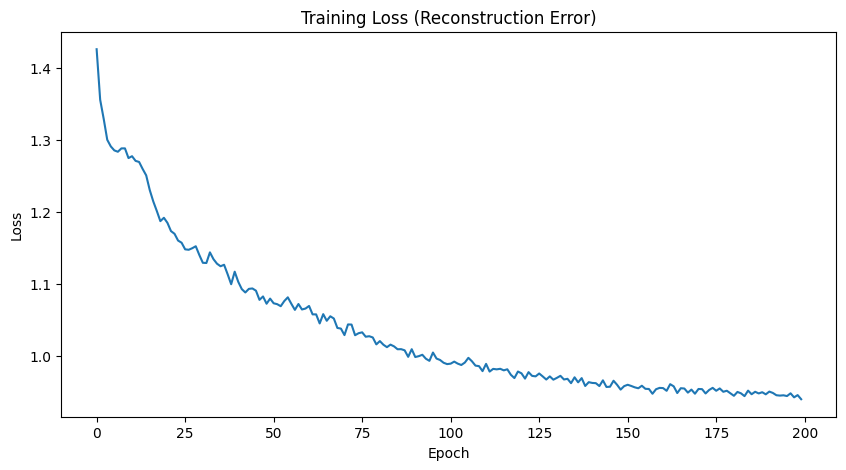

In [5]:
# Training Loop
epochs = 200

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    loss = model.recon_loss(z, data.edge_index)
    loss.backward()
    optimizer.step()
    return float(loss)

losses = []
for epoch in range(1, epochs + 1):
    loss = train()
    losses.append(loss)
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss (Reconstruction Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Step 6: Detect Anomalies (Calculate Scores)

We define an anomaly score for each provider. A common approach in graph anomaly detection is to look at how well the model can reconstruct the features of a node given its neighbors. We will use the trained encoder to get the latent representation $Z$, and then a simple linear decoder to reconstruct the original features $X$. The Mean Squared Error (MSE) between the original features and the reconstructed features will be our anomaly score. High error means the provider's features are unexpected given the graph structure.

In [6]:
# Get latent embeddings
model.eval()
z = model.encode(data.x, data.edge_index)

# Reconstruct features from latent space
# We can train a simple linear decoder to map Z back to X to measure feature reconstruction error
# This helps identify nodes whose features are unusual given their structural context
from sklearn.linear_model import LinearRegression

z_np = z.detach().cpu().numpy()
x_np = data.x.detach().cpu().numpy()

# Fit a linear model to reconstruct X from Z
# In a full GAE with feature reconstruction, this would be part of the training loss
feature_decoder = LinearRegression()
feature_decoder.fit(z_np, x_np)
x_recon = feature_decoder.predict(z_np)

# Calculate Mean Squared Error for each node
mse = np.mean((x_np - x_recon) ** 2, axis=1)
anomaly_scores = mse

# Add scores to DataFrame
df_sample['Anomaly_Score'] = anomaly_scores

print(f"Anomaly scores calculated for {len(anomaly_scores)} providers.")
print(df_sample[['National Provider Identifier', 'Anomaly_Score']].head())

Anomaly scores calculated for 10000 providers.
   National Provider Identifier  Anomaly_Score
0                    1295782100       0.002583
1                    1730189408       0.042877
2                    1144215336       0.007008
3                    1184844169       0.004876
4                    1255530580       0.002296


## Step 7: Identifying Suspicious Nodes

We sort the providers by their Anomaly Score in descending order. The top providers are the most anomalous. Note that **anomaly ≠ fraud**, but rather "significantly different from peers". This list gives auditors a prioritized starting point.

In [7]:
# Sort by anomaly score descending
top_anomalies = df_sample.sort_values(by='Anomaly_Score', ascending=False)

# Display top 10 most anomalous providers
print("Top 10 Most Anomalous Providers:")
print(top_anomalies[['National Provider Identifier', 'Provider Type', 'Number of Services', 'Average Medicare Allowed Amount', 'Anomaly_Score']].head(10))

# Save the results to CSV if needed
top_anomalies.to_csv('potential_anomalies.csv', index=False)
print("Saved sorted list to 'potential_anomalies.csv'")

Top 10 Most Anomalous Providers:
      National Provider Identifier               Provider Type  \
4601                    1699710665             General Surgery   
5498                    1033281324         Clinical Laboratory   
3401                    1609274505  Ambulatory Surgical Center   
9434                    1548274749   Interventional Cardiology   
6407                    1568918746  Ambulatory Surgical Center   
5978                    1326005307          Orthopedic Surgery   
5078                    1962452649          Orthopedic Surgery   
7292                    1184964728         Clinical Laboratory   
2745                    1023118916                   Pathology   
5306                    1053372649         Hematology-Oncology   

      Number of Services  Average Medicare Allowed Amount  Anomaly_Score  
4601               153.0                     10296.580000     149.687515  
5498             53368.0                        12.636102     122.864014  
3401           

## Step 8: Visualization - Understanding the Provider Network

### How to Read This Graph:
- Each **dot (node)** = One healthcare provider (a doctor or clinic).
- Each **line (edge)** = A connection between two providers whose billing patterns are similar (based on KNN from Step 3).

### What the Colors Mean:
- **Red / Orange nodes** = Providers flagged as **suspicious** (high reconstruction error — the GNN model couldn't reconstruct their patterns well, meaning they behave very differently from the majority).
- **Blue nodes** = **Normal** providers that the model reconstructed easily.

### Why Are There Multiple Disconnected Groups (Clusters)?
We're only plotting the **top 30 anomalies and their immediate neighbors**—not the entire 10,000-node graph. Each disconnected cluster is a group of anomalies that happen to share neighbors with each other. If two anomalies are in different specialties (e.g., one is a cardiologist, another is a podiatrist), their neighbors are completely different providers, so they appear as **separate islands** in the plot. They are NOT connected in the full graph either because their billing behavior is too different to be KNN neighbors.

### Why Are Some Blue Nodes Connected to a Red Node?
A blue node next to a red node means that provider *looks similar* to the anomaly based on raw features (they are KNN neighbors). But the blue node itself has a low anomaly score — the model could reconstruct it fine. The red node, despite being *somewhat similar* to its neighbors, still has unusual enough patterns that the model flagged it.

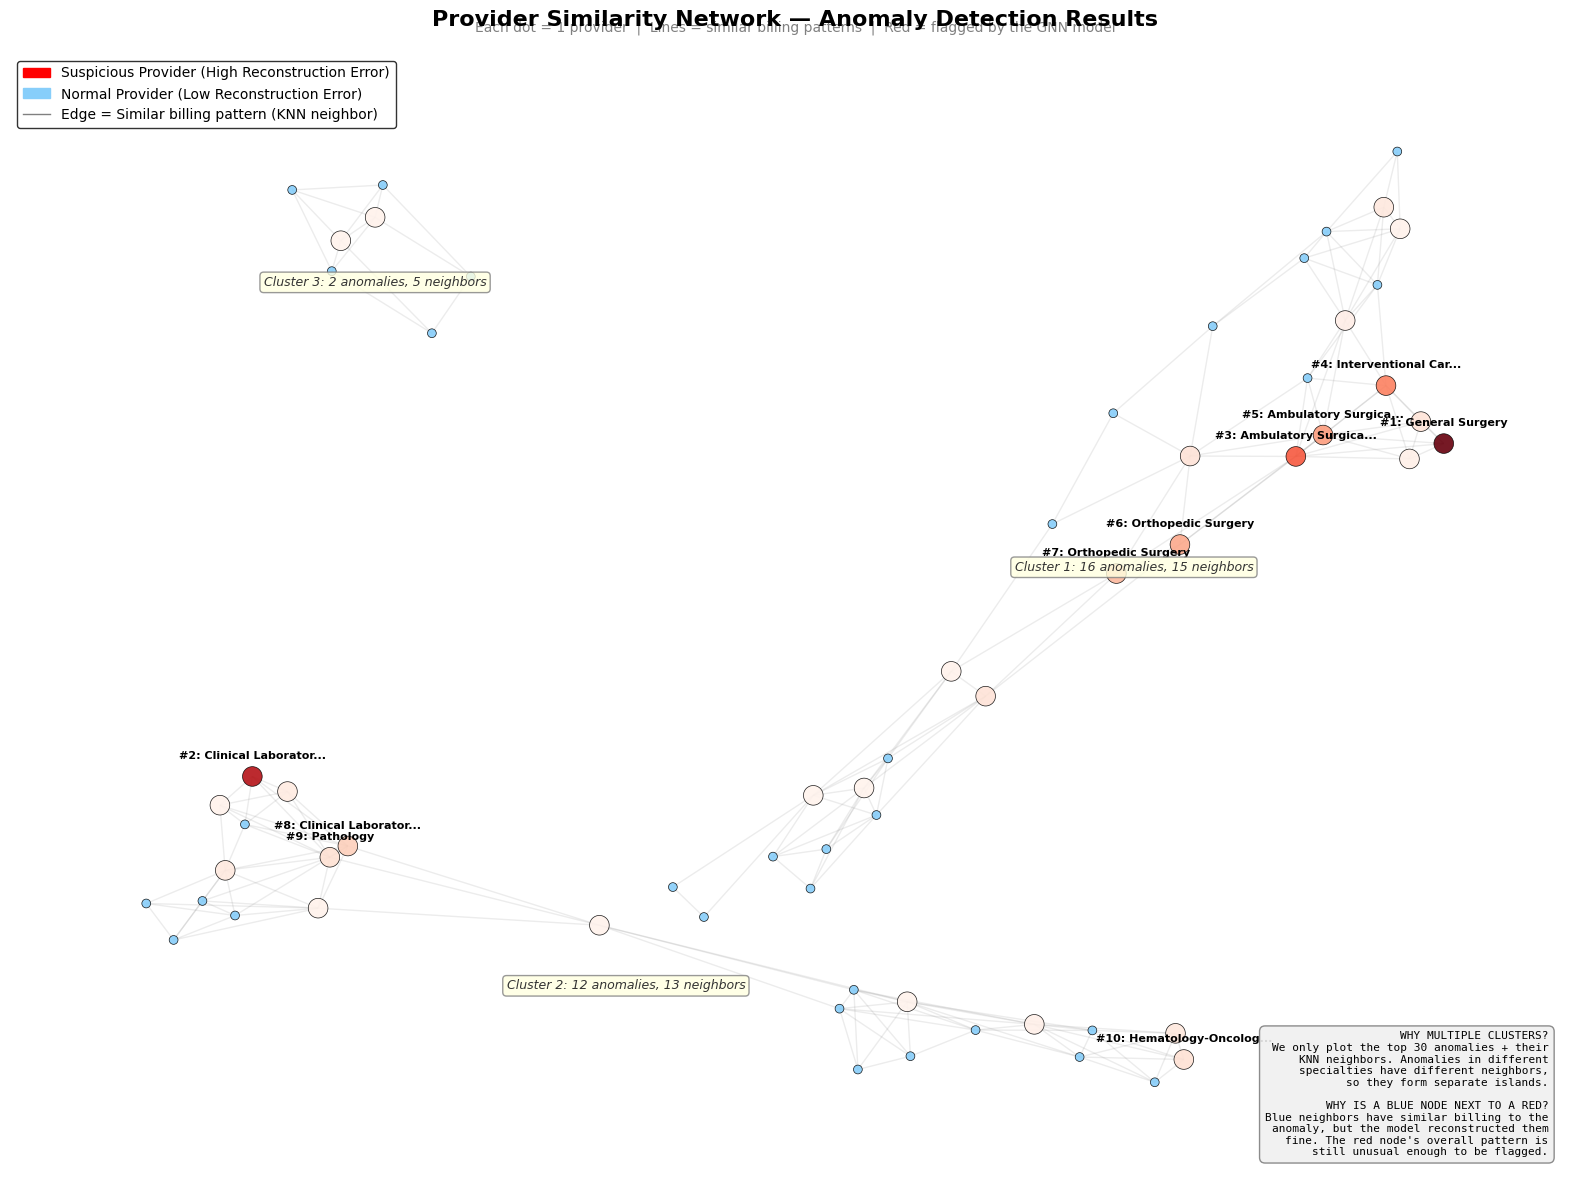


The subgraph has 3 disconnected cluster(s):
  Cluster 1: 31 nodes total (16 anomalies, 15 normal neighbors)
  Cluster 2: 25 nodes total (12 anomalies, 13 normal neighbors)
  Cluster 3: 7 nodes total (2 anomalies, 5 normal neighbors)


In [8]:
### ---- FIGURE 1: Annotated Network Graph ---- ###
from torch_geometric.utils import to_networkx
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Convert graph back to NetworkX (CPU)
data_cpu = data.cpu()
G_full = to_networkx(data_cpu, to_undirected=True)

# Identify the indices of the top 30 anomalies
anomaly_indices = top_anomalies.index[:30].tolist()
anomaly_set = set(anomaly_indices)

# Find the neighbors of these anomalies
neighbors_of_anomalies = set()
for idx in anomaly_indices:
    if idx in G_full:
        neighbors_of_anomalies.update(list(G_full.neighbors(idx)))

# Build subgraph with anomalies + their neighbors
subset_nodes = list(anomaly_set | neighbors_of_anomalies)
G_sub = G_full.subgraph(subset_nodes).copy()

# ----- Assign visual properties to each node -----
# Use a color gradient: highest anomaly = dark red, normal = blue
all_scores = df_sample['Anomaly_Score']
score_norm = Normalize(vmin=all_scores.min(), vmax=all_scores.max())

node_colors = []
node_sizes = []
labels = {}

for node in G_sub.nodes():
    score = df_sample.loc[node, 'Anomaly_Score']
    if node in anomaly_set:
        # Color on a gradient from orange (lower anomaly) to dark red (highest anomaly)
        node_colors.append(cm.Reds(score_norm(score)))
        node_sizes.append(200)
        # Label the top 10 anomalies with their Provider Type
        rank = anomaly_indices.index(node) + 1 if node in anomaly_indices[:10] else None
        if rank:
            ptype = str(df_sample.loc[node, 'Provider Type'])
            if len(ptype) > 18:
                ptype = ptype[:18] + "..."
            labels[node] = f"#{rank}: {ptype}"
    else:
        node_colors.append('#87CEFA')  # Light blue
        node_sizes.append(40)

# ----- Draw the graph -----
fig, ax = plt.subplots(figsize=(16, 12))

pos = nx.spring_layout(G_sub, seed=42, k=0.3, iterations=80)

# Draw edges first (behind nodes)
nx.draw_networkx_edges(G_sub, pos, alpha=0.15, edge_color='gray', ax=ax)

# Draw nodes
nx.draw_networkx_nodes(G_sub, pos, node_color=node_colors, node_size=node_sizes,
                       alpha=0.9, edgecolors='black', linewidths=0.5, ax=ax)

# Draw labels with a slight offset so they don't overlap the dot
label_pos = {k: (v[0], v[1] + 0.04) for k, v in pos.items()}
nx.draw_networkx_labels(G_sub, label_pos, labels, font_size=8, font_weight='bold',
                        font_color='black', ax=ax)

# ----- Legend -----
red_patch = mpatches.Patch(color='red', label='Suspicious Provider (High Reconstruction Error)')
blue_patch = mpatches.Patch(color='#87CEFA', label='Normal Provider (Low Reconstruction Error)')
gray_line = plt.Line2D([0], [0], color='gray', linewidth=1, label='Edge = Similar billing pattern (KNN neighbor)')
ax.legend(handles=[red_patch, blue_patch, gray_line], loc='upper left', fontsize=10,
          frameon=True, facecolor='white', edgecolor='black')

# ----- Annotations explaining the structure -----
# Find the connected components to annotate them
components = list(nx.connected_components(G_sub))
components.sort(key=len, reverse=True)  # Largest first

# Annotate each cluster
for i, comp in enumerate(components[:4]):  # Annotate up to 4 clusters
    comp_nodes = list(comp)
    # Get center of this cluster
    xs = [pos[n][0] for n in comp_nodes if n in pos]
    ys = [pos[n][1] for n in comp_nodes if n in pos]
    if not xs:
        continue
    cx, cy = np.mean(xs), np.mean(ys)
    
    n_anomalies_in_cluster = len([n for n in comp_nodes if n in anomaly_set])
    n_normal_in_cluster = len(comp_nodes) - n_anomalies_in_cluster
    
    # Place annotation below the cluster
    ax.annotate(
        f"Cluster {i+1}: {n_anomalies_in_cluster} anomalies, {n_normal_in_cluster} neighbors",
        xy=(cx, cy - 0.08), fontsize=9, ha='center',
        style='italic', color='#333333',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', edgecolor='gray', alpha=0.8)
    )

# ----- Title & Subtitle -----
ax.set_title("Provider Similarity Network — Anomaly Detection Results",
             fontsize=16, fontweight='bold', pad=20)
ax.text(0.5, 1.02,
        "Each dot = 1 provider  |  Lines = similar billing patterns  |  Red = flagged by the GNN model",
        transform=ax.transAxes, fontsize=10, ha='center', color='gray')

# Explanation box in bottom-right
explanation = (
    "WHY MULTIPLE CLUSTERS?\n"
    "We only plot the top 30 anomalies + their\n"
    "KNN neighbors. Anomalies in different\n"
    "specialties have different neighbors,\n"
    "so they form separate islands.\n\n"
    "WHY IS A BLUE NODE NEXT TO A RED?\n"
    "Blue neighbors have similar billing to the\n"
    "anomaly, but the model reconstructed them\n"
    "fine. The red node's overall pattern is\n"
    "still unusual enough to be flagged."
)
ax.text(0.98, 0.02, explanation, transform=ax.transAxes, fontsize=8,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#f0f0f0', edgecolor='gray', alpha=0.9),
        family='monospace')

ax.axis('off')
plt.tight_layout()
plt.show()

# Print a summary of the clusters
print(f"\nThe subgraph has {len(components)} disconnected cluster(s):")
for i, comp in enumerate(components):
    n_anom = len([n for n in comp if n in anomaly_set])
    print(f"  Cluster {i+1}: {len(comp)} nodes total ({n_anom} anomalies, {len(comp)-n_anom} normal neighbors)")

## Step 9: Anomaly Score Distribution

This chart has **two layers** plotted on top of each other:

1. **The Blue Bars (Histogram)**: Each bar represents a *range* of anomaly scores (a "bin"). The height of a bar = how many providers fall in that score range. The first bar is extremely tall because ~9,800 providers have near-zero scores. The remaining bars are short and wide because only a few providers have higher scores.

2. **The Smooth Curve (KDE Line)**: This is called a **Kernel Density Estimate** — it's just a smoothed version of the bars to show the overall shape. It looks like an exponential decay because the number of providers drops off rapidly as the score increases. It is **not a separate dataset** — it's the same data drawn as a smooth line instead of choppy bars.

3. **The Red Dashed Line (Threshold)**: This marks **Mean + 2 Standard Deviations** — a statistical cutoff. Providers to the right of this line are in the top ~2.5% most unusual.

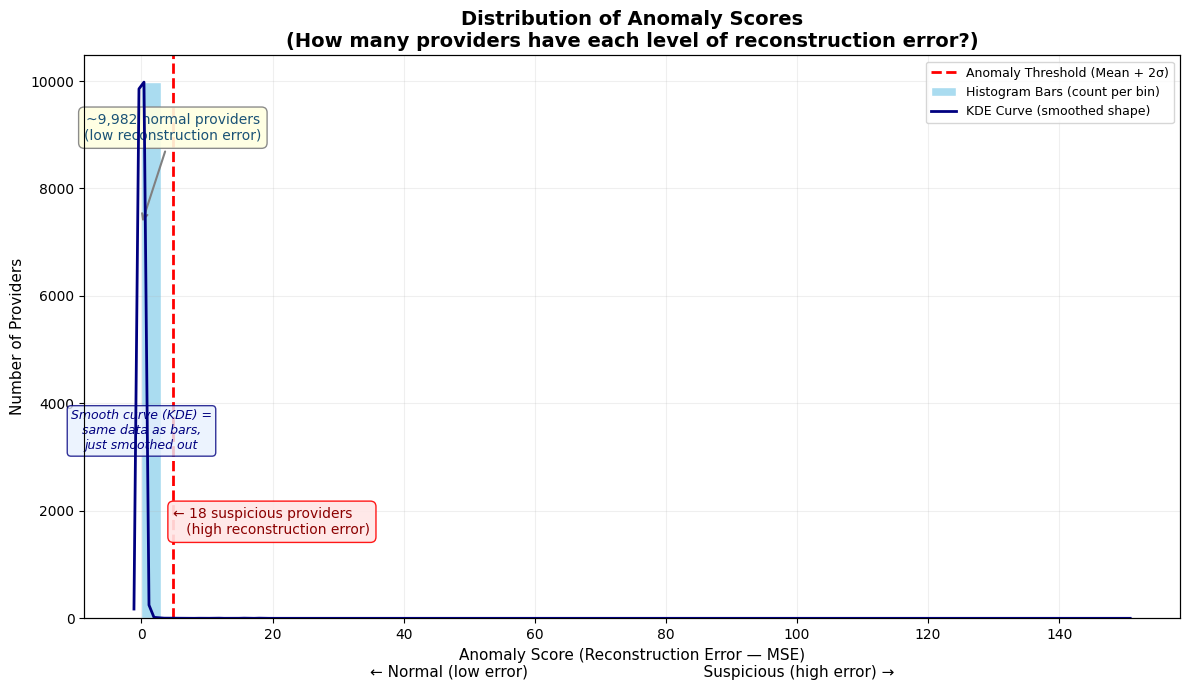


Summary:
  Total providers analyzed: 10,000
  Providers BELOW threshold (normal): 9,982 (99.8%)
  Providers ABOVE threshold (suspicious): 18 (0.2%)
  Threshold value: 4.8798


In [9]:
# Plot histogram of anomaly scores — with annotations explaining each visual element
fig, ax = plt.subplots(figsize=(12, 7))

scores = df_sample['Anomaly_Score']
threshold = scores.mean() + 2 * scores.std()
n_above = (scores > threshold).sum()
n_total = len(scores)

# 1. HISTOGRAM BARS — each bar = count of providers in that score range
sns.histplot(scores, bins=50, kde=False, color='skyblue', edgecolor='white', alpha=0.7, ax=ax, label='Histogram Bars (count per bin)')

# 2. KDE CURVE — smoothed version of the bars (same data, different view)
ax2 = ax.twinx()  # Secondary y-axis so the KDE curve is visible even when bars are tall
sns.kdeplot(scores, color='navy', linewidth=2, ax=ax2, label='KDE Curve (smoothed shape)')
ax2.set_ylabel('')
ax2.set_yticks([])  # Hide secondary y-axis ticks — it's just for shape

# 3. THRESHOLD LINE
ax.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Anomaly Threshold (Mean + 2σ)')

# ---- ANNOTATIONS directly on the chart ----

# Annotate the tall spike
ax.annotate(
    f"~{n_total - n_above:,} normal providers\n(low reconstruction error)",
    xy=(scores.median(), ax.get_ylim()[1] * 0.7),
    fontsize=10, ha='center', color='#1a5276',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', edgecolor='gray', alpha=0.9),
    arrowprops=dict(arrowstyle='->', color='gray', lw=1.5),
    xytext=(scores.quantile(0.5) + scores.std() * 2, ax.get_ylim()[1] * 0.85)
)

# Annotate the long tail
tail_x = threshold + scores.std() * 0.5
ax.annotate(
    f"← {n_above} suspicious providers\n   (high reconstruction error)",
    xy=(threshold, ax.get_ylim()[1] * 0.15),
    fontsize=10, ha='left', color='darkred',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='#ffe6e6', edgecolor='red', alpha=0.9)
)

# Annotate the KDE curve
ax.annotate(
    "Smooth curve (KDE) =\nsame data as bars,\njust smoothed out",
    xy=(scores.quantile(0.85), ax.get_ylim()[1] * 0.3),
    fontsize=9, ha='center', color='navy', style='italic',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='#e8f0fe', edgecolor='navy', alpha=0.8)
)

# Labels and title
ax.set_title("Distribution of Anomaly Scores\n(How many providers have each level of reconstruction error?)",
             fontsize=14, fontweight='bold')
ax.set_xlabel("Anomaly Score (Reconstruction Error — MSE)\n← Normal (low error)                                    Suspicious (high error) →",
              fontsize=11)
ax.set_ylabel("Number of Providers", fontsize=11)

# Combined legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9, frameon=True)

ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"  Total providers analyzed: {n_total:,}")
print(f"  Providers BELOW threshold (normal): {n_total - n_above:,} ({(n_total-n_above)/n_total*100:.1f}%)")
print(f"  Providers ABOVE threshold (suspicious): {n_above:,} ({n_above/n_total*100:.1f}%)")
print(f"  Threshold value: {threshold:.4f}")

## Step 10: Extracting Insights for Class Presentation

To make your presentation compelling, you need to show **"Why"** these nodes were flagged. We will create two artifacts for your slides:
1. **The "Red Flag" Table**: A detailed look at the top 5 suspicious providers.
2. **Normal vs. Suspicious Comparison**: A side-by-side comparison showing how the top anomaly deviates from the average provider.

In [10]:
# 1. Prepare detailed anomaly table for slides
presentation_columns = [
    'National Provider Identifier',
    'Last Name/Organization Name of the Provider',
    'First Name of the Provider',
    'Provider Type',
    'State Code of the Provider',
    'Number of Services',
    'Average Medicare Allowed Amount',
    'Average Medicare Payment Amount'
]

# Get the top 5 anomalies
top_5_anomalies = top_anomalies[presentation_columns].head(5).copy()

# Add a formatted 'Name' column for easier reading
def format_name(row):
    if pd.isna(row['First Name of the Provider']): # Check for NaN properly
        return f"{row['Last Name/Organization Name of the Provider']}"
    return f"{row['First Name of the Provider']} {row['Last Name/Organization Name of the Provider']}"

top_5_anomalies['Formatted Name'] = top_5_anomalies.apply(format_name, axis=1)

# Display for Screenshot
print("\n=== TOP 5 SUSPICIOUS PROVIDERS (For Presentation Slides) ===")
# to_markdown requires 'tabulate' package
try:
    print(top_5_anomalies[['Formatted Name', 'Provider Type', 'State Code of the Provider', 'Average Medicare Payment Amount']].to_markdown(index=False))
except ImportError:
    print("Tabulate package not found. Using standard print:")
    print(top_5_anomalies[['Formatted Name', 'Provider Type', 'State Code of the Provider', 'Average Medicare Payment Amount']])

# 2. Compare "Normal" vs "Suspicious"
# Calculate averages for the entire dataset (Normal Behavior)
average_stats = df_sample[features].mean()

# Get stats for the #1 Anomaly
top_anomaly_stats = top_anomalies.iloc[0][features]

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': features,
    'Average Provider': average_stats.values,
    'Top Suspicious Provider': top_anomaly_stats.values
})

# Add a 'Multiplier' column to show how much higher the anomaly is
comparison_df['Deviation (x Times Normal)'] = comparison_df['Top Suspicious Provider'] / comparison_df['Average Provider']

print("\n=== COMPARISON: NORMAL VS SUSPICIOUS (For 'Why It's An Anomaly' Slide) ===")
try:
    print(comparison_df.round(2).to_markdown(index=False))
except ImportError:
    print("Tabulate package not found. Using standard print:")
    print(comparison_df.round(2))

# Save these specific tables for easy copy-pasting
top_5_anomalies.to_csv('presentation_top_5_anomalies.csv', index=False)
comparison_df.to_csv('presentation_comparison.csv', index=False)
print("\nSaved presentation data to 'presentation_top_5_anomalies.csv' and 'presentation_comparison.csv'")


=== TOP 5 SUSPICIOUS PROVIDERS (For Presentation Slides) ===
| Formatted Name                                      | Provider Type              | State Code of the Provider   |   Average Medicare Payment Amount |
|:----------------------------------------------------|:---------------------------|:-----------------------------|----------------------------------:|
| JOHN HOVORKA                                        | General Surgery            | TX                           |                         8065.97   |
| ADVANCED CLINICAL LABORATORIES, INC.                | Clinical Laboratory        | FL                           |                           12.3818 |
| BAY AREA SURGICAL SPECIALIST SERVICES, LLC          | Ambulatory Surgical Center | CA                           |                         2236.5    |
| SUNDEEP DAS                                         | Interventional Cardiology  | MO                           |                         2700.51   |
| ORTHOPEDIC SURGERY CENTE